In [1]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000-001ext.root"

In [2]:
from mu2etools import *
from mu2etools import wideband

processor = wideband.DataProcessor(usexroot=True, fixtimes=True)
ar, arSpills = processor.getData(DATASET)

hep.style.use('ATLAS')  # or ATLAS/LHCb2


In [3]:
#remove older data with FEB enclosers not being mounted on the rack
ar = ar[ar['runNumber']>1172]

In [4]:
list_febID = ar['febID'].to_list()
FEBID = min(list_febID, key=lambda x: len(x))

NFEBS=len(FEBID)
print("Dataset: %s"%DATASET)
print("Number of FEBs: %d"%NFEBS)
print("List of FEBs: %s"%FEBID)

Dataset: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000-001ext.root
Number of FEBs: 6
List of FEBs: [25, 17, 22, 14, 20, 1]


In [5]:
#Mask channels which were not calibrated or had stuck temperatures    
arSPERaw = ak.mask(ar['calibConstants'], (ar['stddevTemperatures']>0.001) & (ar['calibConstants']>0)).to_numpy()
arSPECor = ak.mask(ar['calibConstantsTemperatureCorrected'], (ar['stddevTemperatures']>0.001) & (ar['calibConstantsTemperatureCorrected']>0)).to_numpy()
arTemp = ak.mask(ar["meanTemperatures"], (ar['stddevTemperatures']>0.001)).to_numpy()


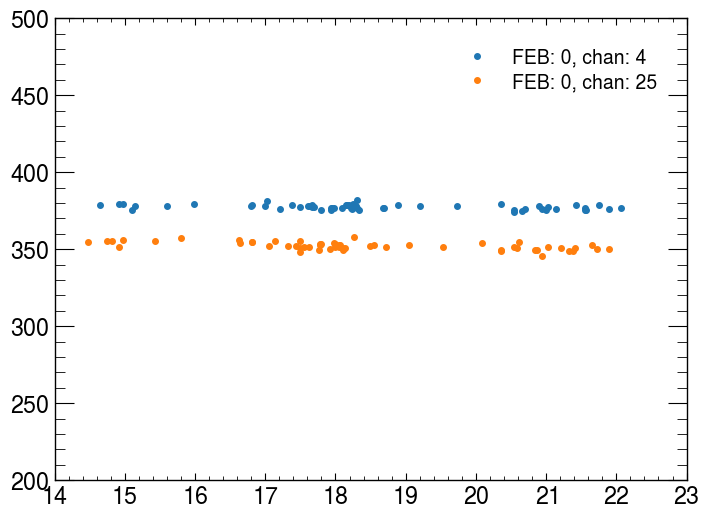

In [6]:
def plotChannel(feb, chan):
    x=arTemp[:, feb, chan]
    y=arSPECor[:, feb, chan]
    mask = ~np.isnan(y)
    x=x[mask]
    y=y[mask]

    plt.plot(x, y, '.', label="FEB: %d, chan: %d"%(feb,chan));
    plt.ylim(200, 500)
    plt.legend()
    
plotChannel(0, 4);
plotChannel(0, 25);


In [7]:
def plotMultiSPE(arrX, arrY):
    from scipy import stats

    df = pd.DataFrame(columns=['feb', 'chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])
    for feb in range(NFEBS):

        fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(24, 2), sharey=True)
        plt.suptitle("FEB%d" % feb)
        plt.subplots_adjust(wspace=0)

        for chan in range(64):
            x=arrX[:, feb, chan]
            y=arrY[:, feb, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d, %d"%(feb,chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            new_row = {'feb': feb, 'chan': chan, 'slope': slope, 'intercept': intercept, 
                       'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
            df.loc[len(df)] = new_row

            ax = axs[chan//4]
            markers = ax.plot(x, y, '.', markersize=2.0, label='%d: %.1f+%.1fx'%(chan, intercept, slope))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.5)
            ax.legend(fontsize='xx-small')
    return df

In [8]:
def plotSPE(x,y):
    plt.figure()
    for feb in range(NFEBS):
        df_ = df.query('feb==%d'%feb)
        plt.plot(df_[x], df_[y], '.', label='feb: %d'%feb)
        plt.ylabel(y)
        plt.xlabel(x)
        plt.legend();

Temperature Corrected SPEs

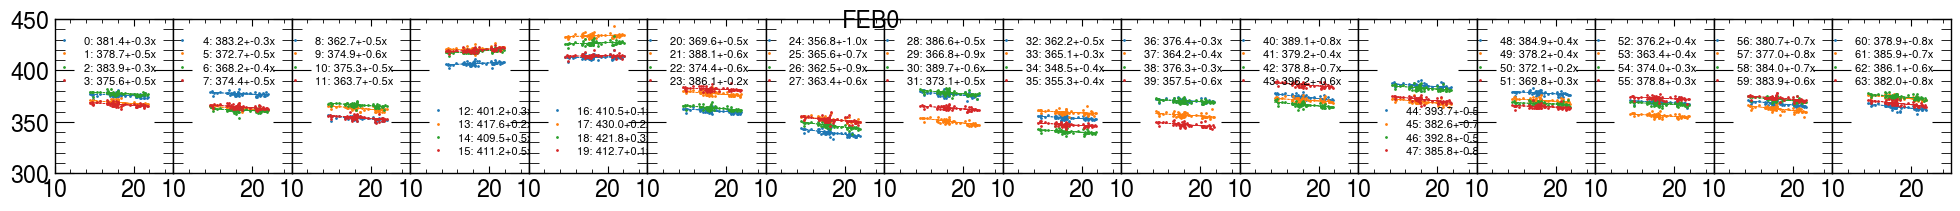

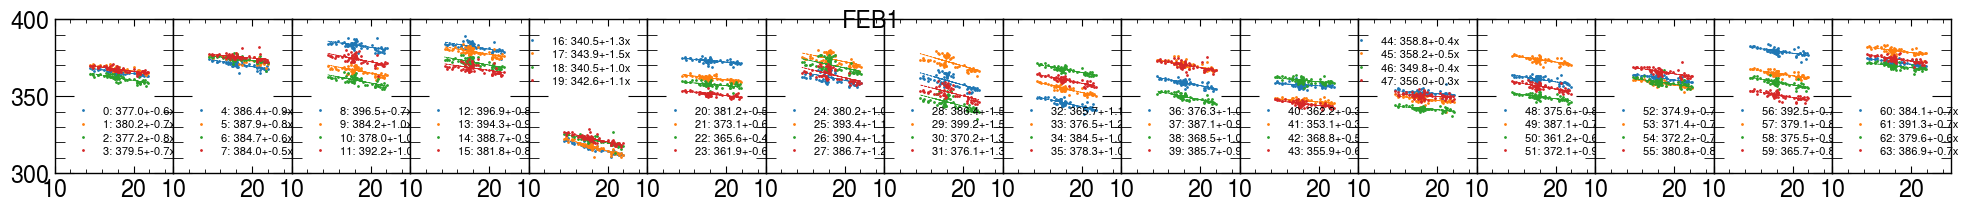

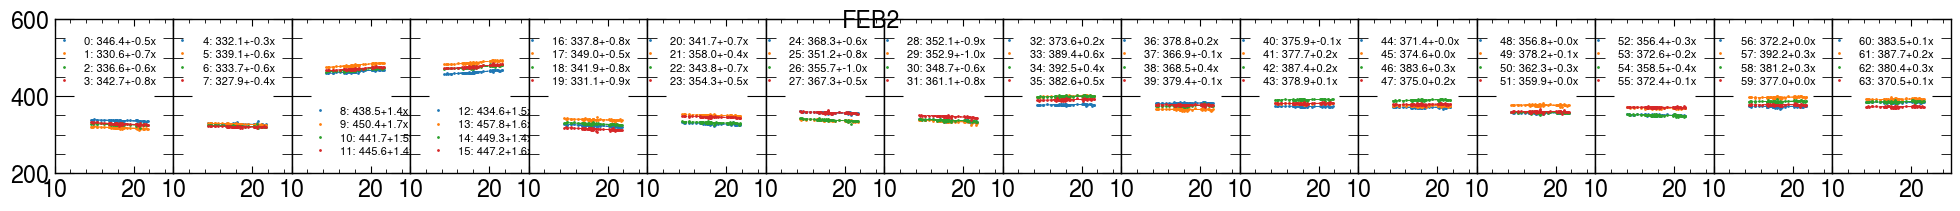

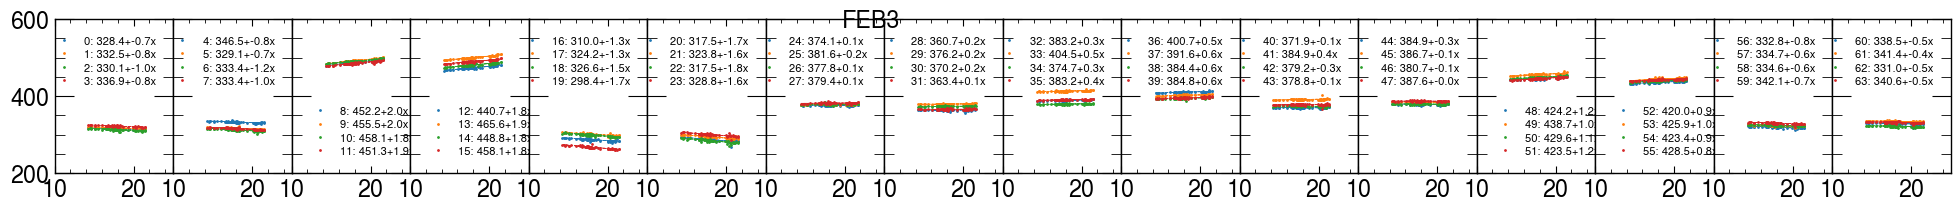

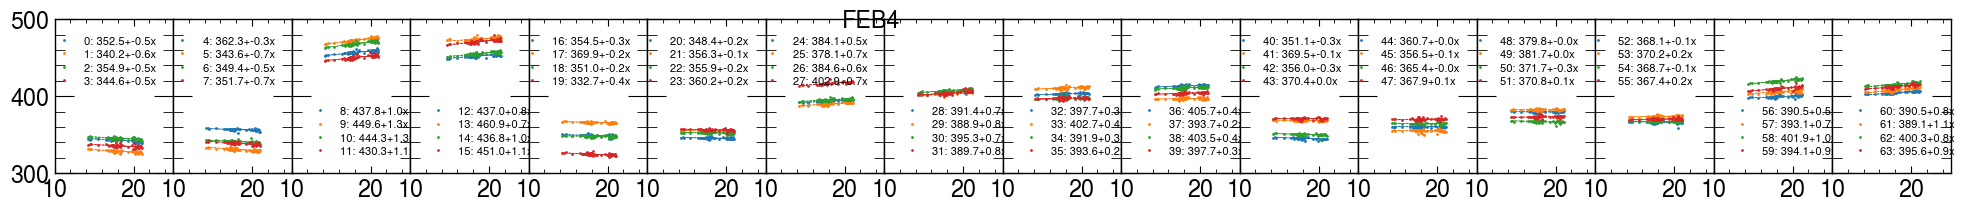

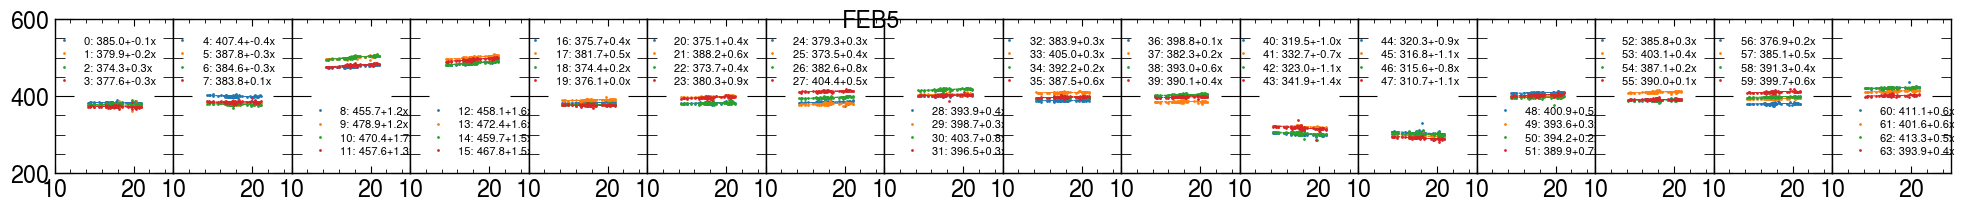

In [9]:
df = plotMultiSPE(arTemp, arSPECor)

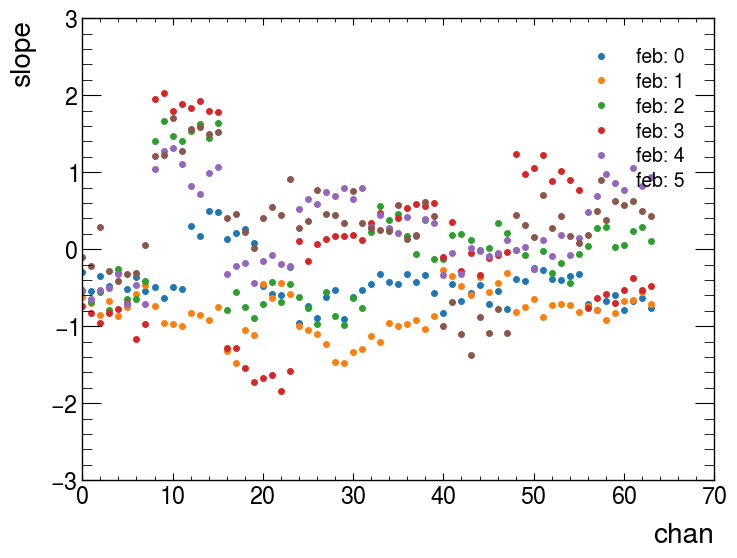

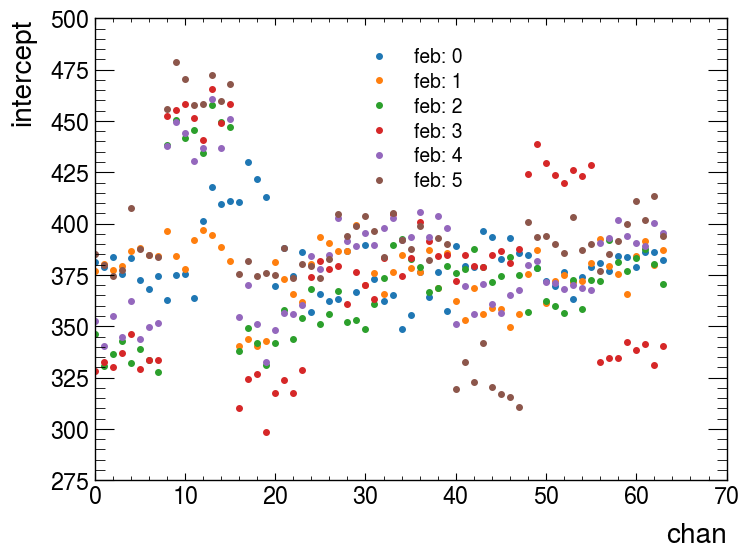

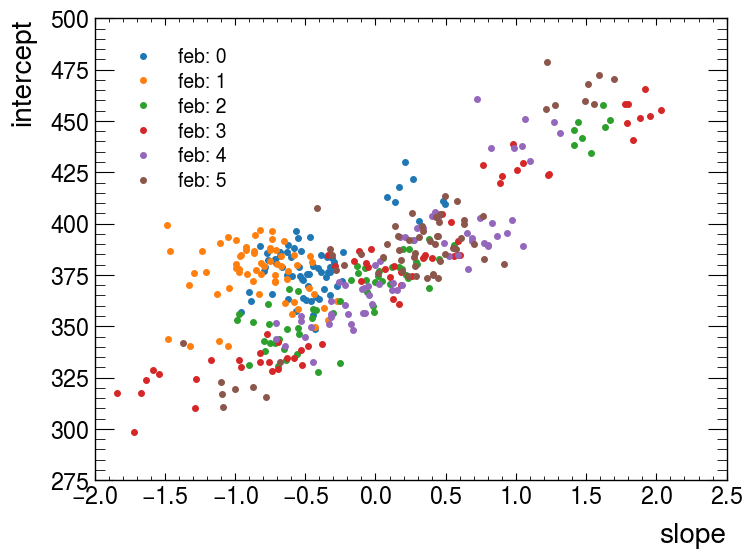

In [10]:
plotSPE('chan', 'slope');        
plotSPE('chan', 'intercept');        
plotSPE('slope', 'intercept');

Raw SPEs

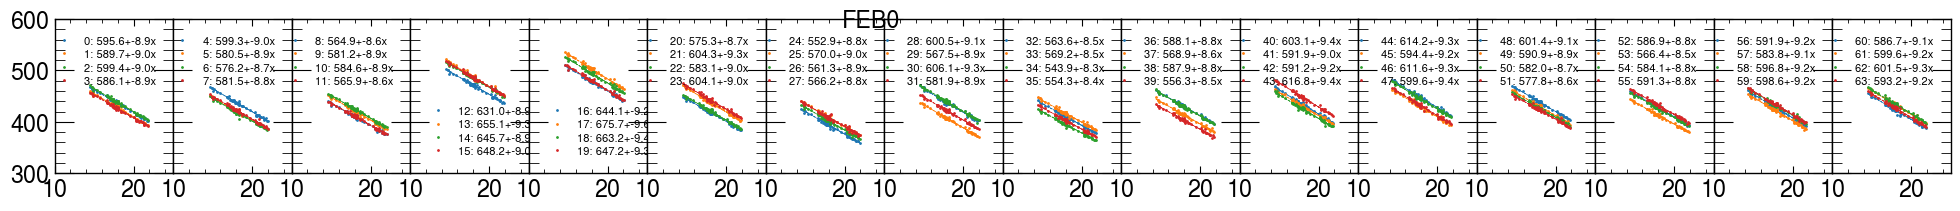

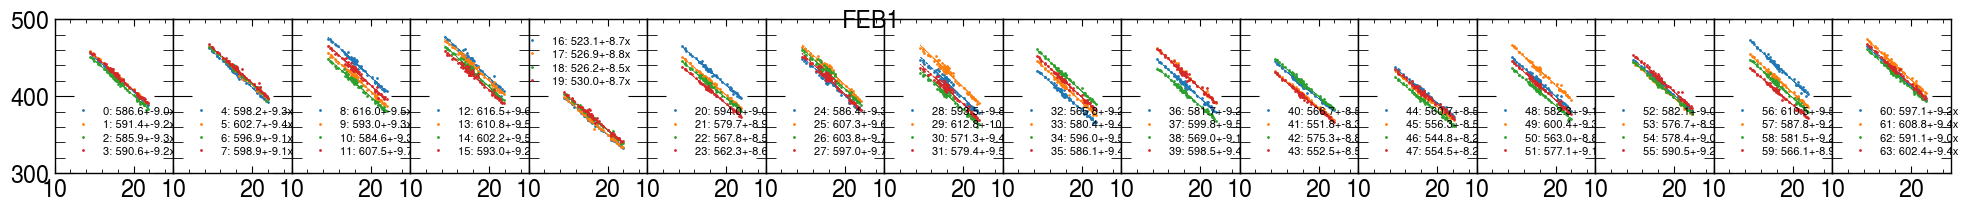

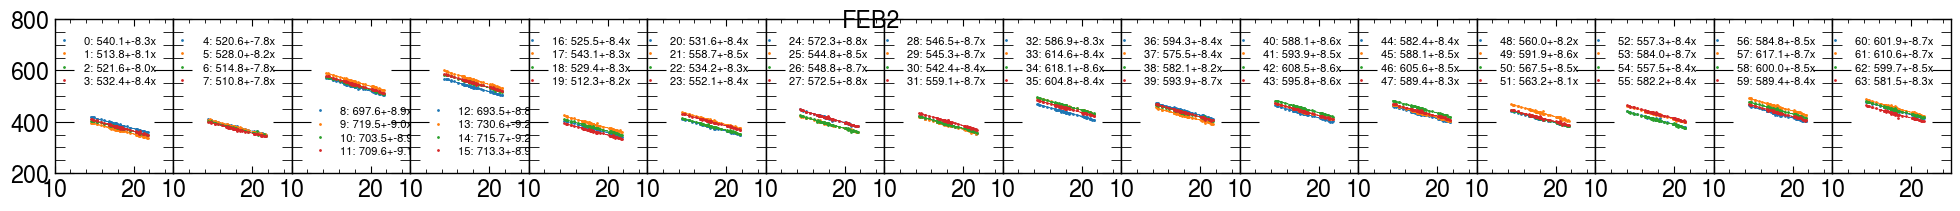

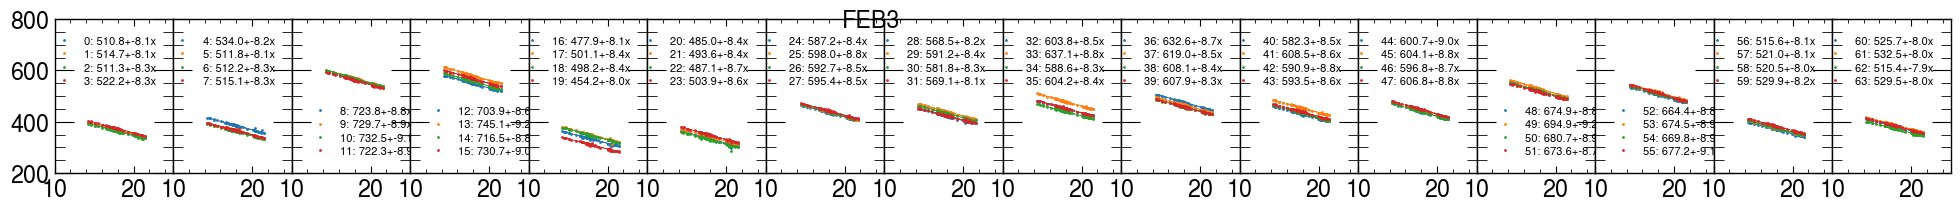

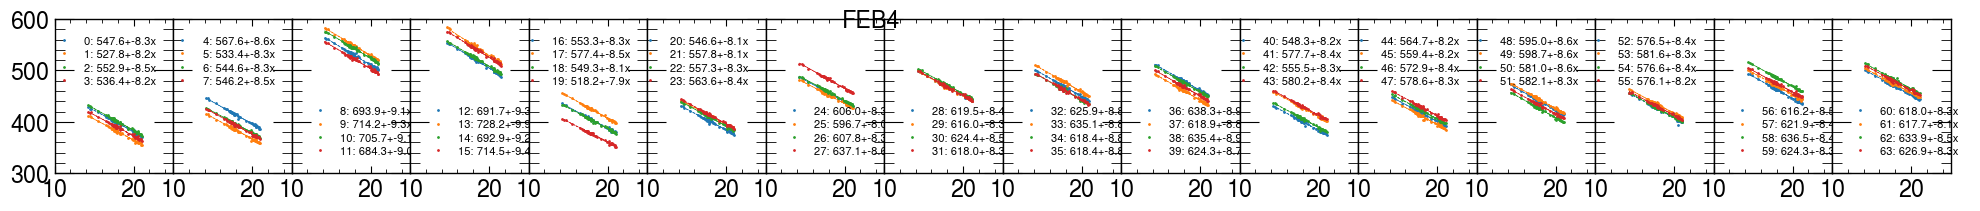

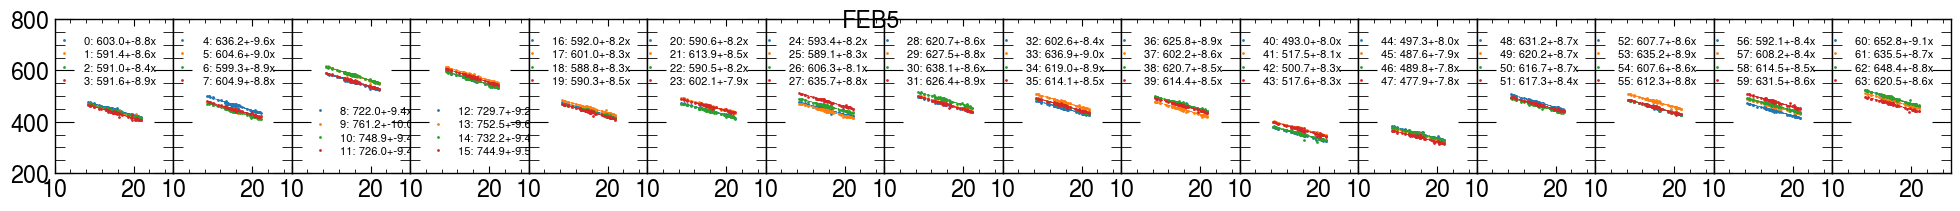

In [11]:
df = plotMultiSPE(arTemp, arSPERaw)

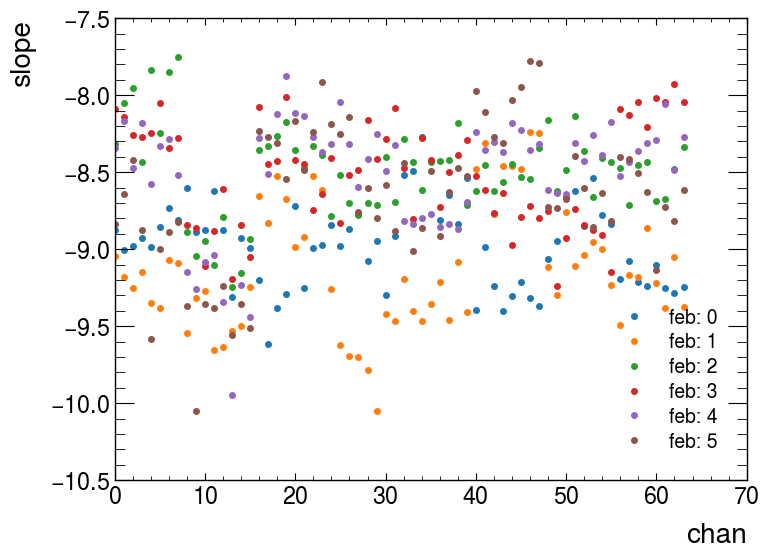

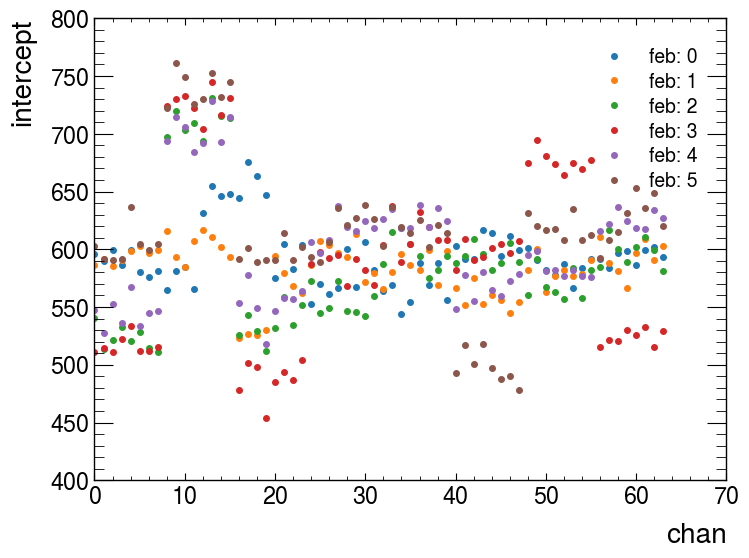

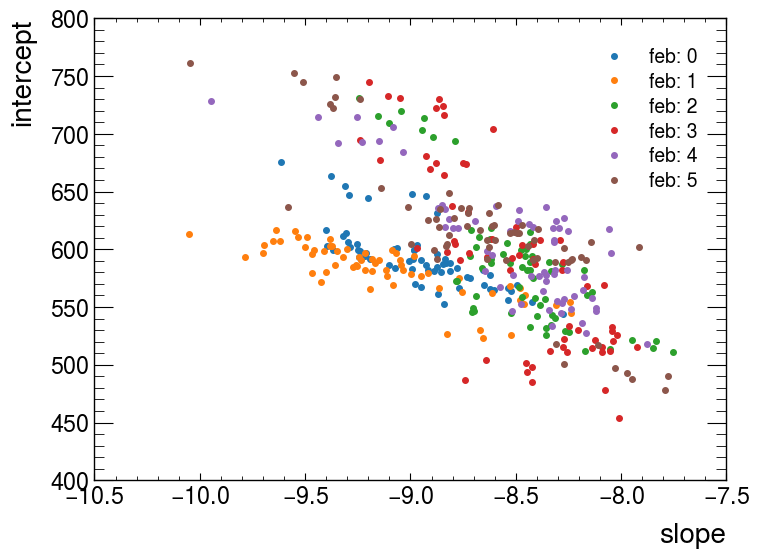

In [12]:
plotSPE('chan', 'slope');        
plotSPE('chan', 'intercept');        
plotSPE('slope', 'intercept');

In [13]:
import datetime
current_time = datetime.datetime.now()
print(DATASET)
print("Current time:", current_time)

rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000-001ext.root
Current time: 2023-07-12 03:54:08.476071
